In [8]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (5000, 784), (10000, 784))

In [9]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [31]:
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)

        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def onehot(self, labels):
#         y = np.zeros([labels.size, np.max(labels) + 1])
        y = np.zeros([labels.size, self.C])
        y[range(labels.size), labels] = 1.
        return y

    def squared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]

        data_loss = 0.5 * np.sum((y_pred - self.onehot(y_train))**2)/ m

        return data_loss

    def dsquared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = (y_pred - self.onehot(y_train))/ m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.squared_loss(y_pred=y_prob, y_train=y_train)
        dy = self.dsquared_loss(y_pred=y_prob, y_train=y_train)
        
        return loss, dy

    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # Softmax backward
        dy = dy - dy_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
#         dy =  dy @ self.W_fixed[2].T # done
        dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dy = dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
#             dy =  dy @ self.W_fixed[2].T # done
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
        dy = dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [32]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 100 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-0.4473, acc-0.1400, valid loss-0.4485, acc-0.1162, test loss-0.4485, acc-0.1156
Iter-20, train loss-0.4495, acc-0.1000, valid loss-0.4488, acc-0.1158, test loss-0.4488, acc-0.1141
Iter-30, train loss-0.4492, acc-0.1400, valid loss-0.4490, acc-0.1154, test loss-0.4489, acc-0.1181
Iter-40, train loss-0.4496, acc-0.1000, valid loss-0.4494, acc-0.1144, test loss-0.4493, acc-0.1188
Iter-50, train loss-0.4484, acc-0.1800, valid loss-0.4497, acc-0.1152, test loss-0.4495, acc-0.1182
Iter-60, train loss-0.4504, acc-0.0800, valid loss-0.4500, acc-0.1166, test loss-0.4498, acc-0.1214
Iter-70, train loss-0.4504, acc-0.0900, valid loss-0.4503, acc-0.1194, test loss-0.4500, acc-0.1242
Iter-80, train loss-0.4490, acc-0.1700, valid loss-0.4504, acc-0.1226, test loss-0.4501, acc-0.1295
Iter-90, train loss-0.4502, acc-0.0900, valid loss-0.4504, acc-0.1282, test loss-0.4501, acc-0.1374
Iter-100, train loss-0.4489, acc-0.1600, valid loss-0.4503, acc-0.1306, test loss-0.4500, acc-0.1431

Iter-830, train loss-0.3725, acc-0.3300, valid loss-0.3531, acc-0.4782, test loss-0.3534, acc-0.4602
Iter-840, train loss-0.3511, acc-0.4900, valid loss-0.3517, acc-0.4862, test loss-0.3521, acc-0.4695
Iter-850, train loss-0.3389, acc-0.5300, valid loss-0.3501, acc-0.4896, test loss-0.3505, acc-0.4773
Iter-860, train loss-0.3480, acc-0.4400, valid loss-0.3488, acc-0.4994, test loss-0.3492, acc-0.4869
Iter-870, train loss-0.3678, acc-0.4100, valid loss-0.3471, acc-0.5028, test loss-0.3476, acc-0.4907
Iter-880, train loss-0.3501, acc-0.5500, valid loss-0.3454, acc-0.5048, test loss-0.3460, acc-0.4932
Iter-890, train loss-0.3595, acc-0.4800, valid loss-0.3439, acc-0.5070, test loss-0.3444, acc-0.4933
Iter-900, train loss-0.3344, acc-0.5500, valid loss-0.3425, acc-0.5084, test loss-0.3431, acc-0.4988
Iter-910, train loss-0.3642, acc-0.4300, valid loss-0.3409, acc-0.5150, test loss-0.3415, acc-0.5061
Iter-920, train loss-0.3349, acc-0.5300, valid loss-0.3393, acc-0.5188, test loss-0.3399, a

Iter-1640, train loss-0.2666, acc-0.6100, valid loss-0.2486, acc-0.6516, test loss-0.2469, acc-0.6583
Iter-1650, train loss-0.2683, acc-0.6700, valid loss-0.2477, acc-0.6532, test loss-0.2460, acc-0.6626
Iter-1660, train loss-0.2467, acc-0.6600, valid loss-0.2468, acc-0.6554, test loss-0.2452, acc-0.6639
Iter-1670, train loss-0.2416, acc-0.6500, valid loss-0.2460, acc-0.6562, test loss-0.2444, acc-0.6668
Iter-1680, train loss-0.2767, acc-0.5900, valid loss-0.2450, acc-0.6590, test loss-0.2435, acc-0.6698
Iter-1690, train loss-0.2572, acc-0.6000, valid loss-0.2439, acc-0.6616, test loss-0.2422, acc-0.6717
Iter-1700, train loss-0.2312, acc-0.6700, valid loss-0.2428, acc-0.6648, test loss-0.2412, acc-0.6721
Iter-1710, train loss-0.2221, acc-0.6800, valid loss-0.2416, acc-0.6658, test loss-0.2400, acc-0.6746
Iter-1720, train loss-0.2419, acc-0.6700, valid loss-0.2405, acc-0.6684, test loss-0.2388, acc-0.6770
Iter-1730, train loss-0.2659, acc-0.6300, valid loss-0.2392, acc-0.6696, test loss

Iter-2450, train loss-0.2212, acc-0.7300, valid loss-0.2044, acc-0.7234, test loss-0.2023, acc-0.7282
Iter-2460, train loss-0.2193, acc-0.7400, valid loss-0.2042, acc-0.7246, test loss-0.2022, acc-0.7292
Iter-2470, train loss-0.1657, acc-0.8300, valid loss-0.2039, acc-0.7252, test loss-0.2020, acc-0.7291
Iter-2480, train loss-0.2295, acc-0.6700, valid loss-0.2040, acc-0.7230, test loss-0.2021, acc-0.7271
Iter-2490, train loss-0.2094, acc-0.7100, valid loss-0.2036, acc-0.7242, test loss-0.2017, acc-0.7272
Iter-2500, train loss-0.1915, acc-0.7500, valid loss-0.2031, acc-0.7250, test loss-0.2014, acc-0.7279
Iter-2510, train loss-0.1904, acc-0.7100, valid loss-0.2027, acc-0.7260, test loss-0.2011, acc-0.7288
Iter-2520, train loss-0.2504, acc-0.6600, valid loss-0.2025, acc-0.7268, test loss-0.2010, acc-0.7291
Iter-2530, train loss-0.2162, acc-0.7000, valid loss-0.2020, acc-0.7280, test loss-0.2005, acc-0.7302
Iter-2540, train loss-0.1942, acc-0.7400, valid loss-0.2017, acc-0.7284, test loss

Iter-3260, train loss-0.1968, acc-0.7300, valid loss-0.1897, acc-0.7492, test loss-0.1898, acc-0.7495
Iter-3270, train loss-0.1652, acc-0.8000, valid loss-0.1897, acc-0.7494, test loss-0.1899, acc-0.7492
Iter-3280, train loss-0.1918, acc-0.7400, valid loss-0.1899, acc-0.7488, test loss-0.1900, acc-0.7483
Iter-3290, train loss-0.1625, acc-0.7900, valid loss-0.1898, acc-0.7500, test loss-0.1901, acc-0.7475
Iter-3300, train loss-0.2045, acc-0.7200, valid loss-0.1895, acc-0.7508, test loss-0.1898, acc-0.7479
Iter-3310, train loss-0.1645, acc-0.7700, valid loss-0.1897, acc-0.7486, test loss-0.1899, acc-0.7480
Iter-3320, train loss-0.2314, acc-0.6700, valid loss-0.1896, acc-0.7500, test loss-0.1898, acc-0.7485
Iter-3330, train loss-0.2071, acc-0.7100, valid loss-0.1895, acc-0.7492, test loss-0.1896, acc-0.7495
Iter-3340, train loss-0.2140, acc-0.7400, valid loss-0.1896, acc-0.7488, test loss-0.1896, acc-0.7490
Iter-3350, train loss-0.1697, acc-0.8000, valid loss-0.1895, acc-0.7476, test loss

Iter-4070, train loss-0.1708, acc-0.7600, valid loss-0.1883, acc-0.7584, test loss-0.1912, acc-0.7525
Iter-4080, train loss-0.1712, acc-0.8100, valid loss-0.1885, acc-0.7564, test loss-0.1914, acc-0.7517
Iter-4090, train loss-0.2161, acc-0.7200, valid loss-0.1887, acc-0.7562, test loss-0.1917, acc-0.7508
Iter-4100, train loss-0.1727, acc-0.7400, valid loss-0.1887, acc-0.7568, test loss-0.1917, acc-0.7504
Iter-4110, train loss-0.1551, acc-0.8300, valid loss-0.1889, acc-0.7570, test loss-0.1920, acc-0.7500
Iter-4120, train loss-0.1827, acc-0.7600, valid loss-0.1888, acc-0.7580, test loss-0.1919, acc-0.7506
Iter-4130, train loss-0.1976, acc-0.7500, valid loss-0.1891, acc-0.7562, test loss-0.1923, acc-0.7507
Iter-4140, train loss-0.1851, acc-0.7400, valid loss-0.1891, acc-0.7556, test loss-0.1923, acc-0.7502
Iter-4150, train loss-0.1964, acc-0.7600, valid loss-0.1894, acc-0.7564, test loss-0.1925, acc-0.7505
Iter-4160, train loss-0.2393, acc-0.6500, valid loss-0.1894, acc-0.7556, test loss

Iter-4880, train loss-0.2245, acc-0.7100, valid loss-0.2019, acc-0.7540, test loss-0.2062, acc-0.7450
Iter-4890, train loss-0.1904, acc-0.7900, valid loss-0.2021, acc-0.7544, test loss-0.2064, acc-0.7441
Iter-4900, train loss-0.2066, acc-0.7300, valid loss-0.2026, acc-0.7516, test loss-0.2069, acc-0.7426
Iter-4910, train loss-0.1923, acc-0.7400, valid loss-0.2029, acc-0.7514, test loss-0.2073, acc-0.7433
Iter-4920, train loss-0.1678, acc-0.7900, valid loss-0.2026, acc-0.7530, test loss-0.2071, acc-0.7438
Iter-4930, train loss-0.2370, acc-0.6900, valid loss-0.2028, acc-0.7524, test loss-0.2072, acc-0.7419
Iter-4940, train loss-0.1992, acc-0.7100, valid loss-0.2031, acc-0.7520, test loss-0.2076, acc-0.7419
Iter-4950, train loss-0.2109, acc-0.7200, valid loss-0.2029, acc-0.7532, test loss-0.2075, acc-0.7440
Iter-4960, train loss-0.2407, acc-0.6800, valid loss-0.2026, acc-0.7544, test loss-0.2072, acc-0.7448
Iter-4970, train loss-0.2387, acc-0.6900, valid loss-0.2028, acc-0.7536, test loss

Iter-5690, train loss-0.2181, acc-0.7500, valid loss-0.2181, acc-0.7386, test loss-0.2231, acc-0.7284
Iter-5700, train loss-0.2226, acc-0.7000, valid loss-0.2184, acc-0.7374, test loss-0.2235, acc-0.7282
Iter-5710, train loss-0.2161, acc-0.7500, valid loss-0.2183, acc-0.7384, test loss-0.2234, acc-0.7293
Iter-5720, train loss-0.2018, acc-0.7500, valid loss-0.2184, acc-0.7366, test loss-0.2234, acc-0.7286
Iter-5730, train loss-0.1959, acc-0.8000, valid loss-0.2183, acc-0.7374, test loss-0.2232, acc-0.7289
Iter-5740, train loss-0.2653, acc-0.6700, valid loss-0.2185, acc-0.7358, test loss-0.2233, acc-0.7281
Iter-5750, train loss-0.2703, acc-0.6300, valid loss-0.2184, acc-0.7372, test loss-0.2232, acc-0.7295
Iter-5760, train loss-0.2620, acc-0.6900, valid loss-0.2185, acc-0.7378, test loss-0.2234, acc-0.7307
Iter-5770, train loss-0.2524, acc-0.6800, valid loss-0.2186, acc-0.7370, test loss-0.2234, acc-0.7300
Iter-5780, train loss-0.2335, acc-0.6800, valid loss-0.2185, acc-0.7344, test loss

Iter-6500, train loss-0.1927, acc-0.7400, valid loss-0.2224, acc-0.7356, test loss-0.2253, acc-0.7259
Iter-6510, train loss-0.2015, acc-0.7700, valid loss-0.2223, acc-0.7348, test loss-0.2254, acc-0.7260
Iter-6520, train loss-0.2428, acc-0.6400, valid loss-0.2223, acc-0.7388, test loss-0.2253, acc-0.7288
Iter-6530, train loss-0.1943, acc-0.8000, valid loss-0.2222, acc-0.7382, test loss-0.2252, acc-0.7290
Iter-6540, train loss-0.2212, acc-0.7400, valid loss-0.2222, acc-0.7372, test loss-0.2250, acc-0.7286
Iter-6550, train loss-0.2341, acc-0.6800, valid loss-0.2222, acc-0.7378, test loss-0.2250, acc-0.7288
Iter-6560, train loss-0.1829, acc-0.7600, valid loss-0.2219, acc-0.7388, test loss-0.2247, acc-0.7299
Iter-6570, train loss-0.2603, acc-0.6800, valid loss-0.2217, acc-0.7386, test loss-0.2245, acc-0.7300
Iter-6580, train loss-0.2298, acc-0.7200, valid loss-0.2216, acc-0.7392, test loss-0.2242, acc-0.7312
Iter-6590, train loss-0.2601, acc-0.6900, valid loss-0.2217, acc-0.7384, test loss

Iter-7310, train loss-0.2055, acc-0.7400, valid loss-0.2168, acc-0.7360, test loss-0.2160, acc-0.7368
Iter-7320, train loss-0.1902, acc-0.7500, valid loss-0.2170, acc-0.7336, test loss-0.2161, acc-0.7361
Iter-7330, train loss-0.2388, acc-0.6800, valid loss-0.2168, acc-0.7364, test loss-0.2158, acc-0.7381
Iter-7340, train loss-0.2419, acc-0.7200, valid loss-0.2170, acc-0.7358, test loss-0.2159, acc-0.7380
Iter-7350, train loss-0.2405, acc-0.6700, valid loss-0.2169, acc-0.7358, test loss-0.2157, acc-0.7394
Iter-7360, train loss-0.2338, acc-0.7000, valid loss-0.2169, acc-0.7338, test loss-0.2156, acc-0.7380
Iter-7370, train loss-0.2125, acc-0.7300, valid loss-0.2171, acc-0.7358, test loss-0.2157, acc-0.7376
Iter-7380, train loss-0.2040, acc-0.7600, valid loss-0.2173, acc-0.7330, test loss-0.2160, acc-0.7380
Iter-7390, train loss-0.2117, acc-0.7400, valid loss-0.2174, acc-0.7338, test loss-0.2160, acc-0.7370
Iter-7400, train loss-0.2503, acc-0.7000, valid loss-0.2171, acc-0.7342, test loss

Iter-8120, train loss-0.2431, acc-0.7100, valid loss-0.2298, acc-0.6988, test loss-0.2275, acc-0.7043
Iter-8130, train loss-0.2287, acc-0.7100, valid loss-0.2295, acc-0.6994, test loss-0.2273, acc-0.7049
Iter-8140, train loss-0.2307, acc-0.7300, valid loss-0.2300, acc-0.6982, test loss-0.2279, acc-0.7040
Iter-8150, train loss-0.1824, acc-0.7900, valid loss-0.2302, acc-0.6982, test loss-0.2279, acc-0.7045
Iter-8160, train loss-0.2299, acc-0.7200, valid loss-0.2297, acc-0.6986, test loss-0.2276, acc-0.7036
Iter-8170, train loss-0.1988, acc-0.7800, valid loss-0.2297, acc-0.6988, test loss-0.2277, acc-0.7016
Iter-8180, train loss-0.2423, acc-0.6400, valid loss-0.2288, acc-0.7010, test loss-0.2269, acc-0.7041
Iter-8190, train loss-0.2570, acc-0.6700, valid loss-0.2291, acc-0.6998, test loss-0.2273, acc-0.7044
Iter-8200, train loss-0.2241, acc-0.7000, valid loss-0.2286, acc-0.6988, test loss-0.2268, acc-0.7043
Iter-8210, train loss-0.2318, acc-0.7100, valid loss-0.2284, acc-0.7014, test loss

Iter-8930, train loss-0.1909, acc-0.7700, valid loss-0.2241, acc-0.7002, test loss-0.2237, acc-0.7090
Iter-8940, train loss-0.2704, acc-0.6100, valid loss-0.2240, acc-0.6998, test loss-0.2235, acc-0.7096
Iter-8950, train loss-0.2395, acc-0.7000, valid loss-0.2241, acc-0.6996, test loss-0.2235, acc-0.7095
Iter-8960, train loss-0.2511, acc-0.6500, valid loss-0.2246, acc-0.6994, test loss-0.2239, acc-0.7097
Iter-8970, train loss-0.2467, acc-0.6700, valid loss-0.2244, acc-0.7000, test loss-0.2238, acc-0.7102
Iter-8980, train loss-0.2160, acc-0.7100, valid loss-0.2243, acc-0.6996, test loss-0.2237, acc-0.7097
Iter-8990, train loss-0.2262, acc-0.6900, valid loss-0.2242, acc-0.6996, test loss-0.2236, acc-0.7097
Iter-9000, train loss-0.1943, acc-0.7300, valid loss-0.2238, acc-0.6994, test loss-0.2233, acc-0.7100
Iter-9010, train loss-0.2239, acc-0.7100, valid loss-0.2239, acc-0.6988, test loss-0.2233, acc-0.7097
Iter-9020, train loss-0.1899, acc-0.7800, valid loss-0.2244, acc-0.6982, test loss

Iter-9740, train loss-0.1896, acc-0.7500, valid loss-0.2288, acc-0.6926, test loss-0.2268, acc-0.6984
Iter-9750, train loss-0.2484, acc-0.6800, valid loss-0.2292, acc-0.6900, test loss-0.2271, acc-0.6975
Iter-9760, train loss-0.1960, acc-0.7600, valid loss-0.2290, acc-0.6910, test loss-0.2269, acc-0.6974
Iter-9770, train loss-0.2202, acc-0.7200, valid loss-0.2289, acc-0.6910, test loss-0.2269, acc-0.6978
Iter-9780, train loss-0.2431, acc-0.6700, valid loss-0.2288, acc-0.6914, test loss-0.2268, acc-0.6976
Iter-9790, train loss-0.1676, acc-0.7700, valid loss-0.2291, acc-0.6916, test loss-0.2272, acc-0.6958
Iter-9800, train loss-0.2641, acc-0.6200, valid loss-0.2290, acc-0.6918, test loss-0.2272, acc-0.6958
Iter-9810, train loss-0.2442, acc-0.6100, valid loss-0.2294, acc-0.6912, test loss-0.2275, acc-0.6954
Iter-9820, train loss-0.2521, acc-0.6400, valid loss-0.2292, acc-0.6916, test loss-0.2272, acc-0.6963
Iter-9830, train loss-0.2576, acc-0.6400, valid loss-0.2294, acc-0.6908, test loss

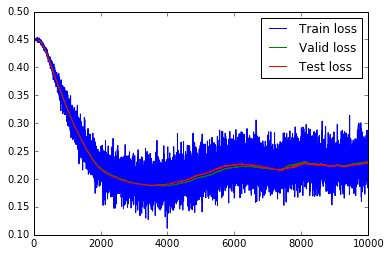

In [33]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

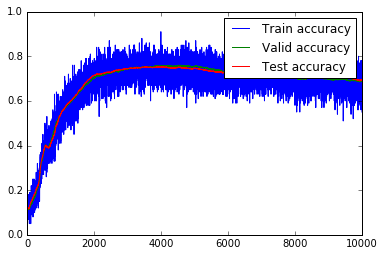

In [34]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()